In [16]:
################################################################################
# CSE 253: Programming Assignment 1
# Code snippet by Jenny Hamer
# Winter 2019
################################################################################
# We've provided you with the dataset in CAFE.tar.gz. To uncompress, use:
# tar -xzvf CAFE.tar.gz
################################################################################
# To install PIL, refer to the instructions for your system:
# https://pillow.readthedocs.io/en/5.2.x/installation.html
################################################################################
# If you don't have NumPy installed, please use the instructions here:
# https://scipy.org/install.html
################################################################################

from os import listdir
from PIL import Image
import numpy as np
from scipy import linalg as la

# The relative path to your CAFE-Gamma dataset
data_dir = "./CAFE/"

# Dictionary of semantic "label" to emotions
emotion_dict = {"h": "happy", "ht": "happy with teeth", "m": "maudlin",
	"s": "surprise", "f": "fear", "a": "anger", "d": "disgust", "n": "neutral"}


from random import shuffle

def shuffle_n_generate_data(train, target):
    length = len(train)
    train = np.array(train,'float64')
    target = np.array(target)
    ind_list = [i for i in range(length)]
    shuffle(ind_list)
    train_new  = train[ind_list,:,:]
    target_new = target[ind_list]
    return train_new, target_new

def load_data(data_dir="./CAFE/"):
    """ Load all PGM images stored in your data directory into a list of NumPy
    arrays with a list of corresponding labels.

    Args:
        data_dir: The relative filepath to the CAFE dataset.
    Returns:
        images: A list containing every image in CAFE as an array.
        labels: A list of the corresponding labels (filenames) for each image.
    """
    # Get the list of image file names
    all_files = listdir(data_dir)

    # Store the images as arrays and their labels in two lists
    images = []
    labels = []

    for file in all_files:
    # Load in the files as PIL images and convert to NumPy arrays
        if file.find('_ht') == -1 and file.find('_n') == -1:
            img = Image.open(data_dir + file)
            images.append(np.array(img))
            labels.append(file)

    print("Total number of images:", len(images), "and labels:", len(labels))

    return images, labels
def data_parse(images, labels):
    train = []
    target = []
    for i in range(len(images)):
        if labels[i].find('_ht') == -1 and labels[i].find('_n') == -1 :
            train.append(images[i])
            if labels[i].find('_h') !=-1:
                target.append(0)
            elif labels[i].find('_m') !=-1:
                target.append(1)
            elif labels[i].find('_s') !=-1:
                target.append(2)
            elif labels[i].find('_f') !=-1:
                target.append(3)
            elif labels[i].find('_a') !=-1:
                target.append(4)
            elif labels[i].find('_d') !=-1:
                target.append(5)
    return train, target

In [4]:
###### TODO  DEVIDE Eigen VEctore to EigenCVALUE

def PCA(data, dims_rescaled_data=2):
    """
    returns: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """
    """
    # mean center the data
    mean = data.mean(axis=1)
    std = data.std(axis=1)
    data = data-mean
    data = data_T.transpose()

    # calculate the covariance matrix
    print(data_T.shape)
    print(data.shape)
    R = np.dot(data_T,data)
    evals, evecs = LA.eigh(R)
    # sort eigenvalue in decreasing order
    idx = NP.argsort(evals)[::-1]
    vect = NP.dot(data,evecs)
    evecs = vect[:,idx]
    # print(evecs.shape)
    evals = evals[idx]
    print(evals)
    evecs = evecs/np.sqrt(evals) 
    evecs = evecs[:,:dims_rescaled_data]
    ##vect = vect-vect.mean(axis = 0)
    #vect = vect[:,:dims_rescaled_data]
    result = NP.dot(data_T,evecs[:,0])
    result = result/np.linalg.norm(evecs[:,0])
    #result = result - result.mean(axis =0) 
    """
    AA = data.T
    mean = AA.mean(axis=1)
    std = AA.std(axis=1)
    A = ((AA.T-mean)).T  ## center the data
    A_T = A.T
    n = A_T.shape[0] 
    sm = np.matmul((1/n)*A_T,A) ## calculate the 
    evals,ev = la.eigh(sm)
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    ev = ev[:,idx] ## 48*48
    result = []
    ev_r = []
    for i in range(dims_rescaled_data):
        ev_i = np.matmul(A,ev[:,i])/(np.linalg.norm(np.matmul(A,ev[:,i]))*np.sqrt(evals[0]))
        ev_r.append(ev_i)
        result.append(np.matmul(A_T,ev_i))
    result = np.array(result).T
    
    return result,np.array(ev_r),evals,mean,std

def test_PCA(data, dims_rescaled_data=2):
    '''
    test by attempting to recover original data array from
    the eigenvectors of its covariance matrix & comparing that
    'recovered' array with the original data
    '''
    _ , _ , eigenvectors = PCA(data, dim_rescaled_data=2)
    data_recovered = NP.dot(eigenvectors, m).T
    data_recovered += data_recovered.mean(axis=0)
    assert NP.allclose(data, data_recovered)


def plot_pca(data):
    from matplotlib import pyplot as MPL
    clr1 =  '#2026B2'
    fig = MPL.figure()
    ax1 = fig.add_subplot(111)
    data_resc, data_orig = PCA(data)
    ax1.plot(data_resc[:, 0], data_resc[:, 1], '.', mfc=clr1, mec=clr1)
    MPL.show()

In [45]:
import numpy as np
images, labels = load_data(data_dir="./CAFE/")
images_p, labels_p = data_parse(images, labels)
images,labels= shuffle_n_generate_data(images_p, labels_p)
im = np.array(images[:48], 'float64')
im_re = np.reshape(im, [len(im), -1])
pca_result,evecs,evals,mean,vari = PCA(im_re, dims_rescaled_data=47)

Total number of images: 60 and labels: 60


In [38]:
def display_six_emotions(images, labels):
    flag = [1]*6
    six_im = []
    six_label = []
    for i in range(len(images)):
        if flag[labels[i]] != 0:
            six_im.append(images[i])
            flag[labels[i]] = 0
            six_label.append(labels[i])
        if sum(flag)== 0:
            break
    return six_im, six_label


In [40]:
six_label

[3, 4, 2, 1, 5, 0]

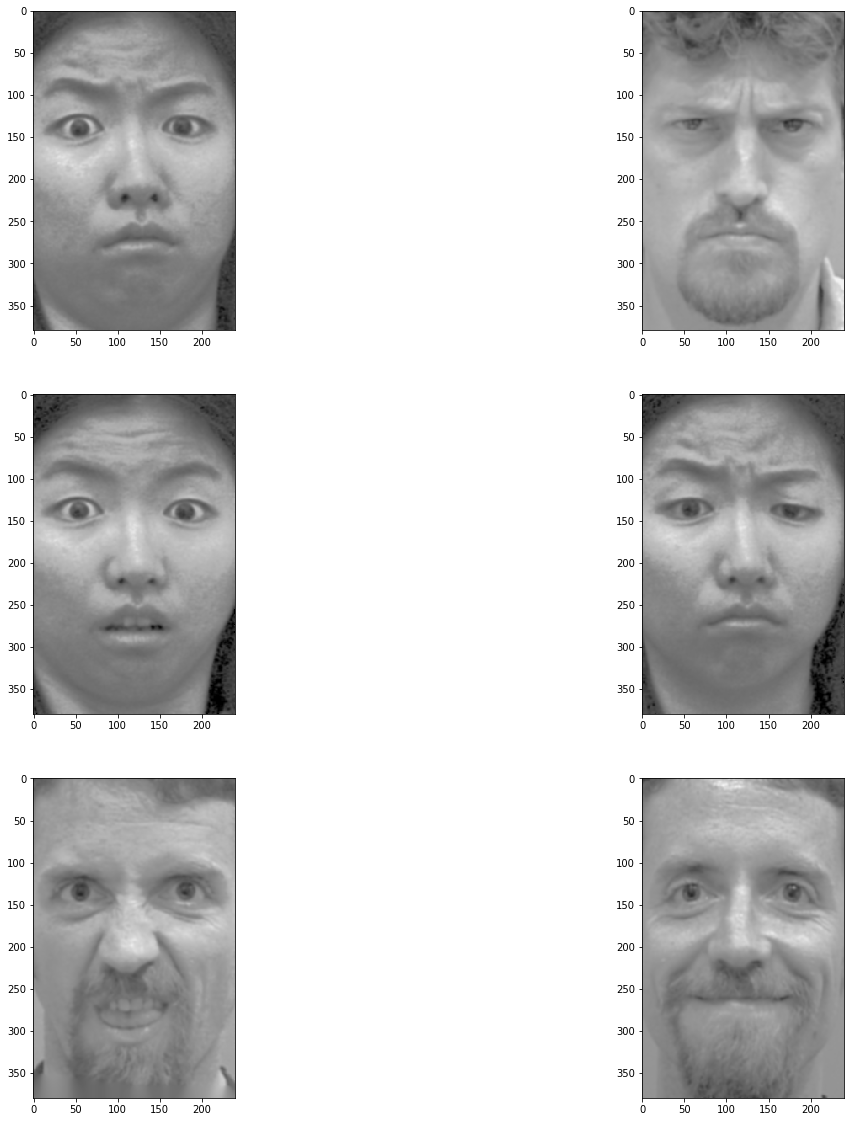

In [44]:
six_im,six_label = display_six_emotions(images, labels)
import numpy as np
import matplotlib.pyplot as plt
columns = 2
rows = 3
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(Image.fromarray(six_im[i-1]))
plt.show()

In [23]:
evecs_pic = np.reshape(evecs[0:6,:],[6,380,-1])
def display_face(img):
    """ Display the input image and optionally save as a PNG.

    Args:
    img: The NumPy array or image to display

    Returns: None
    """
    # Convert img to PIL Image object (if it's an ndarray)
    if type(img) == np.ndarray:
        print("Converting from array to PIL Image")
        im = (img - img.min())*(255/(img.max()-img.min()))
        # normalize the img into 0-255
        img = Image.fromarray(im)
    # Display the image
    img.show()
display_face(evecs_pic[0,:,:])
display_face(evecs_pic[1,:,:])
display_face(evecs_pic[2,:,:])
display_face(evecs_pic[3,:,:])
display_face(evecs_pic[4,:,:])
display_face(evecs_pic[5,:,:])

Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image


## 2.a

In [18]:
def sigmoid(x): 
    return 1. / (1. + np.exp(-x))
def loss(t, y):
    return -(t * np.log(y) +(1 - t) * np.log(1 - y)).mean()
def accuracy(t,p):
    return 1-1.0*sum(abs(t-(p>0.5)))/len(t)
def logistic_regression(features, target, holdout, holdout_label, epoch, learning_rate):
    ce_loss = []
    best_weight = np.zeros(features.shape[1]) 
    weights = np.zeros(features.shape[1])
    holdout_mark = float('inf')
    holdout_loss = []
    m = features.shape[0]
    for step in range(epoch):
        # compute score with new updated weight
        scores = np.dot(features, weights)
        # calculate the sigmoid
        predictions = sigmoid(scores)
        # record Cross-Entropy Error
        ce_loss.append(loss(target,predictions))
        # compute holdout loss
        temp = loss(holdout_label,sigmoid(np.dot(holdout,weights)))
        # find the weight with samllest holdout loss and store as the best weight
        if temp < holdout_mark:
            holdout_mark = temp
            best_weight = weights
        # compute the gradient
        gradient = 1/m * np.dot(features.T, predictions - target)
        
        print(accuracy(target,predictions))
        
        # Update weights with gradient 
        weights -= learning_rate * gradient 
        # record holdout loss for each epoch
        holdout_loss.append(temp)
    return weights, best_weight, np.array(ce_loss), np.array(holdout_loss)


## 2.b

In [8]:
import math
def get_sad(images, labels):
    image_sad = []
    for i in range(len(images)):
        if labels[i].find('_m') != -1:
            image_sad.append(images[i])
    return image_sad

sad_vector = get_sad(images, labels)
sad =np.array(sad_vector,'float64')

def get_happy(images, labels):
    image_happy = []
    for i in range(len(images)):
        if labels[i].find('_h') != -1:
            image_happy.append(images[i])
    return image_happy

happy_vector = get_happy(images, labels)
happy=np.array(happy_vector,'float64')

## 2.b.(1)

In [9]:
ce_loss_lr = []
val_loss_lr = []
lrlist = [0.05, 0.1, 0.5]
for lr in lrlist:
    image_logistic = np.concatenate((sad,happy),axis=0)
    label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
    loss_train = []
    loss_val = []
    test_accuracy = []
    test_results = []
    for i in range (10):
        [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
    
        division = int(0.8*len(image_logistic_s))
        division_2 = int(0.9*len(image_logistic_s))
        # split data into 80% train data, 10% holdout and 10% test data
        train_logistic  = image_logistic_s[:division,:,:]
        train_label_logistic = label_logistic_s[:division]
        holdout_logistic = image_logistic_s[division:division_2,:,:]
        holdout_label_logistic = label_logistic_s[division:division_2]  
        test_logistic  = image_logistic_s[division_2:,:,:]
        test_label_logistic = label_logistic_s [division_2:]
        # perform pca on trainning data to rescale it
        [features_pca,evect,evals,train_mean,train_std] =\
            PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=15)
        # normalize holdout data and rescale it 
        holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
        holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)
        # perform logistic regression
        [weight,best_weight,ce_loss,holdout_loss] = \
            logistic_regression(features_pca, train_label_logistic,\
                holdout_logistic_pca, holdout_label_logistic, epoch = 10, learning_rate = lr)
        # normalize test data and rescale it 
        test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
        test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
        # predict the test result and evaluate the prediction
        test_prediction = sigmoid(np.dot(test_logistic_pca,weight))
        test_result = sigmoid(np.dot(test_logistic_pca,weight))
        # record cross entropy loss, holdout loss and test accuracy over each run
        loss_train.append(ce_loss)
        loss_val.append(holdout_loss)
        test_accuracy.append(accuracy(test_label_logistic,test_result))
        test_results.append(test_result)
        
    loss_avg = np.array(loss_train).mean(axis=0)
    loss_val_avg = np.array(loss_val).mean(axis=0)
    
    print('When learning rate is ' + str(lr))
    print('Average of cross entropy loss is ')
    print(loss_avg)
    print('Average of validation loss is ')
    print(loss_val_avg)
    print('Average of test accuracy is ')
    print(np.array(test_accuracy).mean())
    
    ce_loss_lr.append(loss_avg)
    val_loss_lr.append(loss_val_avg)


When learning rate is 0.05
Average of cross entropy loss is 
[0.69314718 0.69014069 0.68717009 0.68423477 0.68133412 0.67846755
 0.67563448 0.67283432 0.6700665  0.66733048]
Average of validation loss is 
[0.69314718 0.69343052 0.69371801 0.69400945 0.69430462 0.69460333
 0.69490537 0.69521056 0.69551871 0.69582964]
Average of test accuracy is 
0.55
When learning rate is 0.1
Average of cross entropy loss is 
[0.69314718 0.68782052 0.68261139 0.67751562 0.67252916 0.66764813
 0.66286879 0.65818754 0.65360094 0.64910568]
Average of validation loss is 
[0.69314718 0.69270765 0.69227621 0.69185229 0.69143534 0.69102488
 0.69062044 0.69022159 0.68982793 0.6894391 ]
Average of test accuracy is 
0.65
When learning rate is 0.5
Average of cross entropy loss is 
[0.69314718 0.66729915 0.64404622 0.62297648 0.60375112 0.58609311
 0.5697763  0.55461585 0.54046024 0.52718467]
Average of validation loss is 
[0.69314718 0.68911912 0.68547899 0.68213355 0.67901255 0.67606347
 0.67324718 0.67053461 0.6

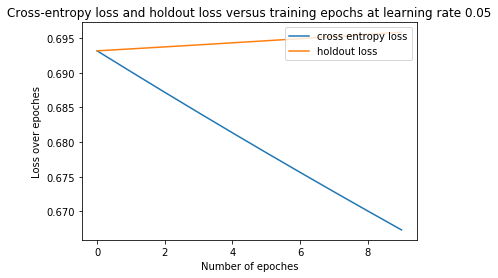

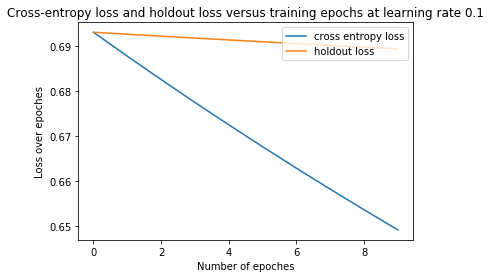

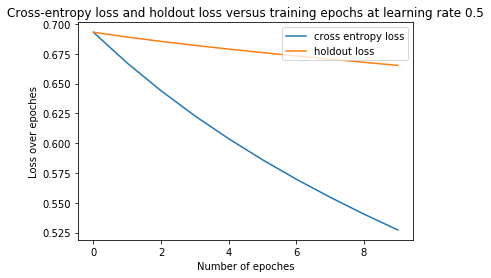

In [11]:
import matplotlib.pyplot as plt

epoch = list(range(10))
for i in range(3):
    plt.plot(epoch, ce_loss_lr[i], label = 'cross entropy loss')
    plt.plot(epoch, val_loss_lr[i], label = 'holdout loss')
    plt.title('Cross-entropy loss and holdout loss versus training epochs at learning rate ' + str(lrlist[i]))
    plt.xlabel('Number of epoches')
    plt.ylabel('Loss over epoches')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
    plt.show()

In [37]:
image_logistic = np.concatenate((sad,happy),axis=0)
label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
loss_train = []
loss_val=[]
test_accuracy = []
test_results = []
for i in range (10):
    [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
    
    division = int(0.8*len(image_logistic_s))
    division_2 = int(0.9*len(image_logistic_s))
    #split data into 80% train data, 10% holdout and 10% test data
    train_logistic  = image_logistic_s[:division,:,:]
    train_label_logistic = label_logistic_s[:division]
    
    holdout_logistic = image_logistic_s[division:division_2,:,:]
    holdout_label_logistic = label_logistic_s[division:division_2]
    
    test_logistic  = image_logistic_s[division_2:,:,:]
    test_label_logistic = label_logistic_s [division_2:]
    #perform pca on trainning data to rescale it
    [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=15)
    #normalize holdout data and rescale it 
    holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
    holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)
    
    [weight,best_weight,ce_loss,holdout_loss] = \
        logistic_regression(features_pca,train_label_logistic,\
        holdout_logistic_pca,holdout_label_logistic,epoch=10, learning_rate=0.1)

    test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
    test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
    test_prediction = sigmoid(np.dot(test_logistic_pca,weight))
    
    test_result = sigmoid(np.dot(test_logistic_pca,weight))
    loss_train.append(ce_loss)
    loss_val.append(holdout_loss)
    test_accuracy.append(accuracy(test_label_logistic,test_result))
    test_results.append(test_result)
    
loss_avg = np.array(loss_train).mean(axis=0)
loss_val_avg = np.array(loss_val).mean(axis=0)

print(loss_avg)
print(loss_val_avg)
print(np.array(test_accuracy).mean())

(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)
(2, 15)
[0.69314718 0.68694907 0.68091065 0.67502613 0.66928987 0.66369645
 0.65824059 0.65291724 0.64772149 0.64264865]
[0.69314718 0.69314412 0.69315793 0.69318703 0.69322991 0.69328515
 0.69335141 0.69342747 0.69351214 0.69360435]
0.5


## 2.c

In [12]:
import math
def get_afraid(images, labels):
    image_afraid = []
    for i in range(len(images)):
        if labels[i].find('_f') != -1:
            image_afraid.append(images[i])
    return image_afraid

afraid_vector = get_afraid(images, labels)
#convert to numpy array
afraid =np.array(afraid_vector,'float64')

def get_suprise(images, labels):
    image_suprise = []
    for i in range(len(images)):
        if labels[i].find('_s') != -1:
            image_suprise.append(images[i])
    return image_suprise

suprise_vector = get_suprise(images, labels)
suprise = np.array(suprise_vector,'float64')

In [19]:
image_logistic = np.concatenate((afraid, suprise),axis=0)
label_logistic = np.concatenate(([0]*10,[1]*10),axis=0)
loss_train = []
loss_val=[]
test_accuracy = []
test_results = []
for i in range (10):
    [image_logistic_s,label_logistic_s] = shuffle_n_generate_data(image_logistic, label_logistic)
    
    division = int(0.8*len(image_logistic_s))
    division_2 = int(0.9*len(image_logistic_s))
    
    train_logistic  = image_logistic_s[:division,:,:]
    train_label_logistic = label_logistic_s[:division]
    
    holdout_logistic = image_logistic_s[division:division_2,:,:]
    holdout_label_logistic = label_logistic_s[division:division_2]
    
    test_logistic  = image_logistic_s[division_2:,:,:]
    test_label_logistic = label_logistic_s [division_2:]
    
    [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_logistic,[len(train_logistic),-1]), dims_rescaled_data=15)
    holdout_logistic_b = np.reshape(holdout_logistic,[len(holdout_logistic),-1])-train_mean
    holdout_logistic_pca = np.matmul(holdout_logistic_b,evect.T)

    [weight,best_weight,ce_loss,holdout_loss] = \
        logistic_regression(features_pca,train_label_logistic,\
        holdout_logistic_pca,holdout_label_logistic,epoch=10, learning_rate=0.5)

    test_logistic_reshape = np.reshape(test_logistic,[len(test_logistic),-1])-train_mean
    test_logistic_pca = np.matmul(test_logistic_reshape,evect.T)
    test_prediction = sigmoid(np.dot(test_logistic_pca,weight))
    
    test_result = sigmoid(np.dot(test_logistic_pca,weight))
    loss_train.append(ce_loss)
    loss_val.append(holdout_loss)
    test_accuracy.append(accuracy(test_label_logistic,test_result))
    test_results.append(test_result)
    
loss_avg = np.array(loss_train).mean(axis=0)
loss_val_avg = np.array(loss_val).mean(axis=0)

print('When learning rate is ' + str(lr))
print('Average of cross entropy loss is ')
print(loss_avg)
print('Average of validation loss is ')
print(loss_val_avg)
print('Average of test accuracy is ')
print(np.array(test_accuracy).mean())

0.4375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.625
0.8125
0.8125
0.875
0.875
0.875
0.9375
1.0
1.0
1.0
0.5
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.5625
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.5625
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.5625
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.625
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.8125
0.875
0.5
0.9375
0.9375
0.9375
0.9375
1.0
1.0
1.0
1.0
1.0
0.5
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.9375
0.9375
0.5
0.8125
0.875
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
When learning rate is 0.5
Average of cross entropy loss is 
[0.69314718 0.66778743 0.64457273 0.62324797 0.60359085 0.5854088
 0.56853549 0.55282734 0.53816028 0.52442683]
Average of validation loss is 
[0.69314718 0.69125542 0.68929756 0.68727509 0.68519601 0.68307211
 0.68091685 0.67874404 0.67656697 0.67439785]
Average of test accuracy is 
0.7


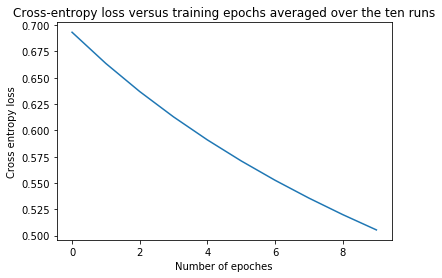

In [17]:
epoch = list(range(10))
plt.plot(epoch, loss_avg)
plt.title('Cross-entropy loss versus training epochs averaged over the ten runs')
plt.xlabel('Number of epoches')
plt.ylabel('Cross entropy loss')
plt.show()

## 3.a

In [28]:
def get_data_for_softmax_re(images, labels):
    train = []
    target = []
    for i in range(len(images)):
        if labels[i].find('_ht') == -1 and labels[i].find('_n') == -1 :
            train.append(images[i])
            if labels[i].find('_h') !=-1:
                target.append(0)
            elif labels[i].find('_m') !=-1:
                target.append(1)
            elif labels[i].find('_s') !=-1:
                target.append(2)
            elif labels[i].find('_f') !=-1:
                target.append(3)
            elif labels[i].find('_a') !=-1:
                target.append(4)
            elif labels[i].find('_d') !=-1:
                target.append(5)
    return train, target
def oneHot(Y,max_val):
    result = []
    for i in range(len(Y)):
        onehot = [0]*(int(max_val)+1)
        onehot[Y[i]] = 1
        result.append(onehot)
    return np.array(result)

def cross_entropy(x, y):
    """ Computes cross entropy between two distributions.
    Input: x: iterabale of N non-negative values
           y: iterabale of N non-negative values
    Returns: scalar
    """

    if np.any(x < 0) or np.any(y < 0):
        raise ValueError('Negative values exist.')

    # Force to proper probability mass function.
    x = np.array(x, dtype=np.float)
    y = np.array(y, dtype=np.float)
    ##x /= np.sum(x)
    ##y /= np.sum(y)

    # Ignore zero 'y' elements.
    mask = y > 0
    #print(x)
    #print(y)
    x = x[mask]
    y = y[mask]    
    ce = -np.sum(np.multiply(x,np.log(y))) 
    return ce

def softmax(x):
    s = np.max(x, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(x - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

def accuracy_softmax(pred,target):
    return sum(pred.argmax(axis=1)==target.argmax(axis=1))/pred.shape[0]
       
def softmax_regression(x,y,handout,handout_label,epoch,learningRate):
    ce_loss = []
    best_weight = np.zeros([x.shape[1],len(np.unique(y))])
    hand_out_mark = float('inf')
    hand_out_loss = []
    weight = np.zeros([x.shape[1],len(np.unique(y))])
    m = x.shape[0] #First we get the number of training examples
    max_val = y.max() 
    y_mat = oneHot(y,max_val) #Next we convert the integer class coding into a one-hot representation
    h_label = oneHot(handout_label,max_val)
    for i in range(0,epoch):
        scores = np.dot(x,weight) #Then we compute raw class scores given our input and current weights
        prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
        temp = cross_entropy(h_label,softmax(np.dot(handout,weight)))
        #print(sigmoid(np.dot(handout,weights)))
        #print(handout_label)
        #print(accuracy_softmax(prob,y_mat))
        if temp < hand_out_mark:
            hand_out_mark = temp
            best_weight = weight
            
        loss = cross_entropy(np.array(y_mat),prob) #We then find the loss of the probabilities
        grad = -np.dot(x.T,(y_mat-prob))  #And compute the gradient for that loss
        ce_loss.append(loss)
        hand_out_loss.append(temp)
        weight = weight -(learningRate * grad)
    return weight, best_weight,np.array(ce_loss),np.array(hand_out_loss)

In [11]:
for ep in [10,20,30,40,50]:    
    loss_train = []
    loss_val=[]
    test_accuracy = []
    for i in range(10):
        [image_softmax, label_softmax] = get_data_for_softmax_re(images, labels)
        image_softmax,label_softmax= shuffle_n_generate_data(image_softmax, label_softmax)
        devision = int(0.8*len(image_softmax))
        devision_2 = int(0.9*len(image_softmax))
        train_softmax  = image_softmax[:devision,:,:]
        train_label_softmax  = label_softmax[:devision]
        holdout_softmax  = image_softmax[devision:devision_2,:,:]
        holdout_label_softmax  = label_softmax[devision:devision_2]
        test_softmax  = image_softmax[devision_2:,:,:]
        test_label_softmax  = label_softmax[devision_2:]
        
        [features_pca,evect,evals,train_mean,train_std] =\
        PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=47)
        
        holdout_softmax_b = np.reshape(holdout_softmax,[len(holdout_softmax),-1])-train_mean
        holdout_softmax_pca = np.matmul(holdout_softmax_b,evect.T)
        
        [weight,best_weight, ce_loss,hand_out_loss] =\
        softmax_regression(features_pca,train_label_softmax,\
                           holdout_softmax_pca,holdout_label_softmax,epoch=ep,learningRate=0.05)
        
        test_softmax_reshape = np.reshape(test_softmax,[len(test_softmax),-1])-train_mean
        test_softmax_pca = np.matmul(test_softmax_reshape,evect.T)
        test_prediction = softmax(np.dot(test_softmax_pca,weight))
    
        loss_train.append(ce_loss)
        loss_val.append(holdout_loss)
        test_accuracy.append(accuracy_softmax(oneHot(test_label_softmax,train_label_softmax.max()),test_prediction))
    
    loss_avg = np.array(loss_train).mean(axis=0)
    loss_val_avg = np.array(loss_val).mean(axis=0)  
    print('training loss of ' + str(ep) + 'is ')
    print(loss_avg)
    print('validation loss of ' + str(ep) + 'is ')
    print(loss_val_avg)
    

training loss of 10is 
[86.00445452 77.653085   70.98248684 65.42178776 60.68047564 56.57789396
 52.98685653 49.81258436 46.98266915 44.44097326]
validation loss of 10is 
[0.69314718 0.67718146 0.66324712 0.65112848 0.64062358 0.6315463
 0.6237273  0.61701402 0.61127014 0.60637461]
training loss of 20is 
[86.00445452 77.86006095 71.28887345 65.775555   61.05572921 56.96373031
 53.38047895 50.2150569  47.39652738 44.86898075 42.58797132 40.51783523
 38.62966572 36.89978995 35.3086239  33.83980875 32.47955581 31.21614552
 30.03954081 28.94108567]
validation loss of 20is 
[0.69314718 0.67718146 0.66324712 0.65112848 0.64062358 0.6315463
 0.6237273  0.61701402 0.61127014 0.60637461]
training loss of 30is 
[86.00445452 77.88822521 71.38955579 65.94294988 61.27020793 57.20441337
 53.62967151 50.45929486 47.62624045 45.07774799 42.77177437 40.67443447
 38.75811368 37.00006208 35.38134163 33.88603304 32.50063384 31.21359758
 30.01497746 28.89614774 27.8495837  26.86868575 25.94763763 25.081290

## 3.b

In [43]:
def softmat_regression_sdg(x,y, epoch,learningRate):
    losses = []
    weight = np.zeros([x.shape[1],len(np.unique(y))])
    m = x.shape[0] #First we get the number of training examples
    max_val = y.max() 
    y_mat = oneHot(y,max_val) #Next we convert the integer class coding into a one-hot representation
    ind_list = [i for i in range(m)]
    for i in range(0,epoch):
        shuffle(ind_list)
        for j in range(m):
            scores = [np.dot(x[ind_list[j]],weight)] #Then we compute raw class scores given our input and current weights
            prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
            grad = -1*np.outer(x[ind_list[j]],(y_mat[ind_list[j]] - prob))#And compute the gradient for that loss
            losses.append(loss)
            weight = weight + (learningRate * grad)
        loss = -1*np.sum(y_mat*np.log(prob)) #We then find the loss of the probabilities
    return weight, losses

In [44]:
[image_softmax, label_softmax] = get_data_for_softmax_re(images, labels)
image_softmax,label_softmax= shuffle_n_generate_data(image_softmax, label_softmax)
devision = int(0.8*len(image_softmax))
devision_2 = int(0.9*len(image_softmax))
train_softmax  = image_softmax[:devision,:,:]
train_label_softmax  = label_softmax[:devision]
        
[features_pca,evect,evals,train_mean,train_std] =\
PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=47)
        
[weight,best_weight,loss_batch,hand_out_loss] =\
softmax_regression(features_pca,train_label_softmax,\
                   holdout_softmax_pca,holdout_label_softmax,epoch=30,learningRate=0.05)

[weight_sdg, loss_sdg]=softmat_regression_sdg(features_pca,train_label_softmax, epoch=30,learningRate=0.05)

In [45]:
loss_sdg

[1.791759469228055,
 1.80688273311996,
 1.7838200478791546,
 1.8048562423661552,
 1.6806055028058993,
 1.8377158728730698,
 1.8231742357881329,
 1.8035537361836105,
 1.791042225237909,
 1.835357178222142,
 1.780050589567633,
 1.7815928934197114,
 1.8171762317923665,
 1.750173617138919,
 1.7867055265347638,
 1.939510986061316,
 1.750047334136254,
 1.7945055841551967,
 1.892375786023438,
 1.538085156626139,
 1.7672969110330488,
 1.8555792714222075,
 1.9335476734921384,
 1.773126020287242,
 1.7504546810927737,
 1.6850556165945592,
 1.7792534893519552,
 1.8855148141846958,
 1.8816093327941052,
 1.8136161914340392,
 1.704535873629746,
 1.8580923646996108,
 1.7604413441441056,
 1.7968860729527814,
 1.6158289785702333,
 1.7961489625045135,
 2.0282363578200955,
 1.7440221468615835,
 2.001162342028502,
 1.9780821775016522,
 2.0116840114810004,
 1.7244710304340605,
 1.8908526904684384,
 1.6902359954500008,
 1.9397910418529123,
 1.8571456692961623,
 1.7291394904902426,
 1.7485924989670947,
 1.908

ValueError: x and y must have same first dimension, but have shapes (30,) and (1440,)

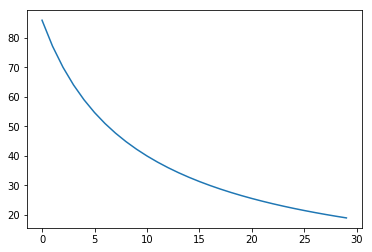

In [46]:
import matplotlib.pyplot as plt
epoch = list(range(30))
plt.plot(epoch, loss_batch, label = 'Batch cross entropy loss')
plt.plot(epoch, loss_sdg, label = 'SDG cross entropy loss')
plt.title('Comparision of BatchGD and SDG Cross-entropy loss versus training epochs at learning rate ' + str(lrlist[i]))
plt.xlabel('Number of epoches')
plt.ylabel('Loss over epoches')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

In [1]:
weight_face = np.matmul(weight.T,evect)
pic = np.reshape(weight_face,[6,380,-1])
display_face(pic[0,:,:])
display_face(pic[1,:,:])
display_face(pic[2,:,:])
display_face(pic[3,:,:])
display_face(pic[4,:,:])
display_face(pic[5,:,:])

NameError: name 'np' is not defined

(48, 380, 240)

In [162]:
def oneHot(Y):
    result = []
    for i in range(len(Y)):
        onehot = [0]*(int(Y.max())+1)
        onehot[Y[i]] = 1
        result.append(onehot)
    return result

def cross_entropy(x, y):
    """ Computes cross entropy between two distributions.
    Input: x: iterabale of N non-negative values
           y: iterabale of N non-negative values
    Returns: scalar
    """

    if np.any(x < 0) or np.any(y < 0):
        raise ValueError('Negative values exist.')

    # Force to proper probability mass function.
    x = np.array(x, dtype=np.float)
    y = np.array(y, dtype=np.float)
    x /= np.sum(x)
    y /= np.sum(y)

    # Ignore zero 'y' elements.
    mask = y > 0
    x = x[mask]
    y = y[mask]    
    ce = -np.sum(x * np.log(y)) 
    return ce
def softmax(x):
    s = np.max(x, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(x - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div
def sofmat_regression(x,y, epoch,learningRate):
    losses = []
    weight = np.zeros([x.shape[1],len(np.unique(y))])
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHot(y) #Next we convert the integer class coding into a one-hot representation
    for i in range(0,epoch):
        scores = np.dot(x,weight) #Then we compute raw class scores given our input and current weights
        prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
        loss = -1/m/6*cross_entropy(np.array(y_mat),np.log(prob)) #We then find the loss of the probabilities
        grad = -1/m/6*np.dot(x.T,(y_mat-prob))  #And compute the gradient for that loss
        losses.append(loss)
        print(loss)
        weight = weight - (learningRate * grad)
    return weight, loss

In [163]:
features_softmax_pca, evect_softmax = PCA(np.reshape(train_softmax,[len(train_softmax),-1]), dims_rescaled_data=47)

ValueError: too many values to unpack (expected 2)

In [604]:
[weight, loss_sofmax] = sofmat_regression(features_softmax_pca,train_label_softmax,epoch=50,learningRate=0.000005)

ValueError: Negative values exist.

In [603]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x.T - np.max(x).T)
    return np.transpose(e_x / e_x.sum())
def sofmat_regression_sdg(x,y, epoch,learningRate):
    losses = []
    weight = np.zeros([x.shape[1],len(np.unique(y))])
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHot(y) #Next we convert the integer class coding into a one-hot representation
    ind_list = [i for i in range(m)]
    for i in range(0,epoch):
        shuffle(ind_list)
        for j in range(m):
            scores = np.dot(x[ind_list[j]],weight) #Then we compute raw class scores given our input and current weights
            prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
            loss = -1*np.sum(y_mat[ind_list[j]]*np.log(prob)) #We then find the loss of the probabilities
            #print(y_mat[ind_list[j]])
            #print(prob.sum())
            grad = -1*np.outer(x[ind_list[j]],(y_mat[ind_list[j]] - prob))#And compute the gradient for that loss
            #print(prob)
            losses.append(loss)
            print(loss)
            weight = weight + (learningRate * grad)
    return weight, loss